### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [ ]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'fsq-n_embed_64k.pt', 'ar-ckpt-best.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=64000, Cvae=6, ch=512, share_quant_resi=6,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

var_checkpoint_data = torch.load(var_ckpt, map_location='cpu')
print("Keys in var_ckpt:", var_checkpoint_data.keys())
print("trainer:", var_checkpoint_data['args'])
# load checkpoints
var_model_state_dict = var_checkpoint_data['trainer']['var_wo_ddp']
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(var_model_state_dict, strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')

Keys in var_ckpt: dict_keys(['epoch', 'iter', 'trainer', 'args'])
trainer: OrderedDict([('data_path', 'imagenette2'), ('exp_name', 'text'), ('vfast', 0), ('tfast', 0), ('depth', 16), ('ini', -1), ('hd', 0.02), ('aln', 0.5), ('alng', 0.001), ('fp16', 1), ('tblr', 0.0001), ('tlr', 3.125e-05), ('twd', 0.05), ('twde', 0.05), ('tclip', 2.0), ('ls', 0.0), ('bs', 80), ('batch_size', 20), ('glb_batch_size', 80), ('ac', 1), ('ep', 50), ('wp', 1.0), ('wp0', 0.005), ('wpe', 0.1), ('sche', 'lin0'), ('opt', 'adamw'), ('afuse', True), ('saln', False), ('anorm', True), ('fuse', True), ('pn', '1_2_3_4_5_6_8_10_13_16'), ('patch_size', 16), ('patch_nums', (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)), ('resos', (16, 32, 48, 64, 80, 96, 128, 160, 208, 256)), ('data_load_reso', 256), ('mid_reso', 1.125), ('hflip', False), ('workers', 2), ('pg', 0.0), ('pg0', 4), ('pgwp', 0.16666666666666666), ('cmd', '--data_path=imagenette2 --device=cuda --depth=16 --bs=80 --ep=50 --fp16=1 --alng=1e-3 --wpe=0.1 --workers=2'), ('bra

RuntimeError: Error(s) in loading state_dict for VAR:
	size mismatch for word_embed.weight: copying a param with shape torch.Size([1024, 6]) from checkpoint, the shape in current model is torch.Size([1024, 4]).
	size mismatch for head.weight: copying a param with shape torch.Size([64000, 1024]) from checkpoint, the shape in current model is torch.Size([1000, 1024]).
	size mismatch for head.bias: copying a param with shape torch.Size([64000]) from checkpoint, the shape in current model is torch.Size([1000]).

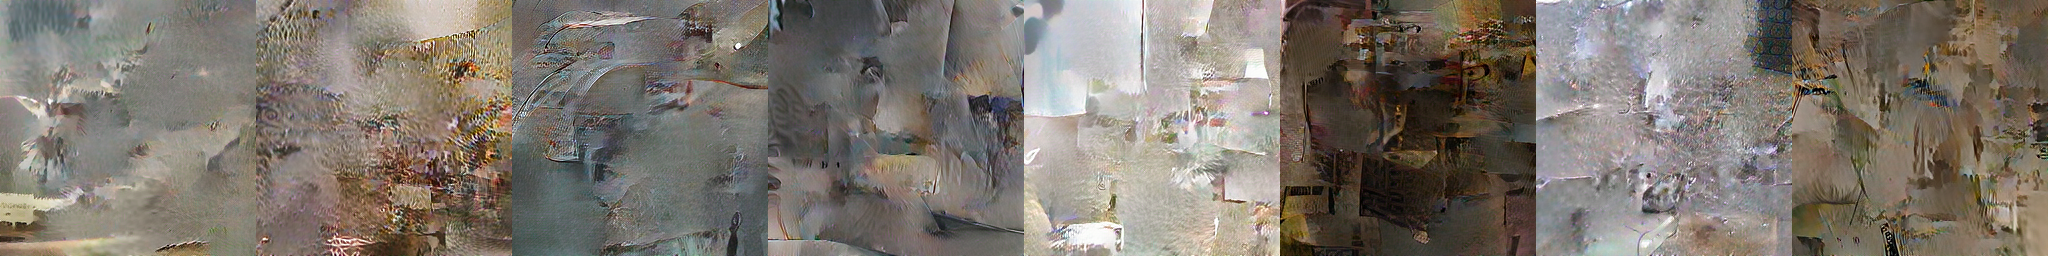

In [18]:
############################# 2. Sample with classifier-free guidance

# set args
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (382, 382, 382, 382, 382, 382, 382, 382)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = len(class_labels)
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
chw.show()
